# This notebook implements a basic CNN for MNIST Digits Classification

In [2]:
# import required libraries
import numpy as np
import torch
# datasets
import torchvision.datasets as datasets
# transforms
import torchvision.transforms as transforms
# for plots
import matplotlib.pyplot as plt
# neural network modules
import torch.nn as nn
# PyTorch utilities
from torch.utils.data import DataLoader
# optimizers
import torch.optim as optim

In [3]:
# set device to cuda(gpu)
device = torch.device("cuda")

## Download the dataset

In [4]:
# downloading with transform

# define transform
transform = transforms.Compose(
    [
        transforms.ToTensor() # Just transform from the image datatype to PyTorch Tensors
    ]
)

# download train and test datasets
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

In [5]:
# extract an image, label pair
image, label = train_dataset[0]
assert image.dtype == torch.float32, "Convert images to tensors"

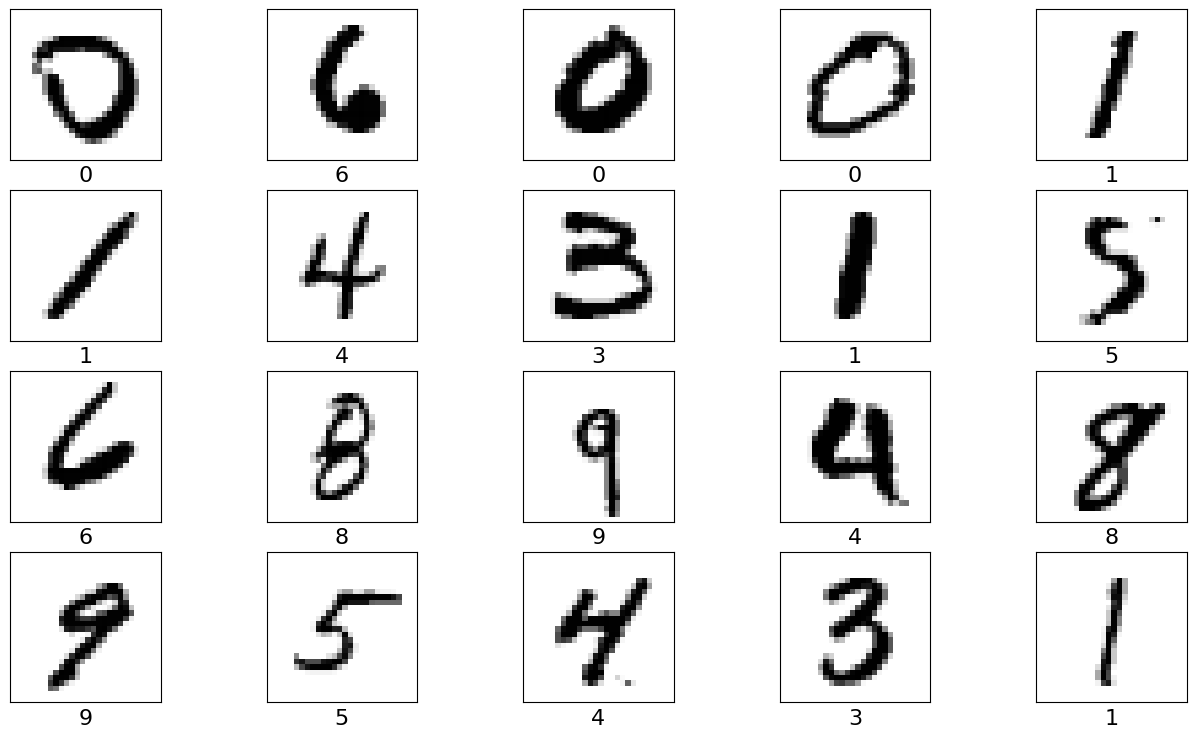

In [6]:
# visualize some images
rand_idxs = np.random.choice(len(train_dataset), 20)
plt.figure(figsize=(16,9))
for i,idx in enumerate(rand_idxs):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    image, label = train_dataset[idx]
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label, fontsize=16)

Above are some images and their labels from training dataset.
### Build CNN Model
Starting with a simple CNN model:
1. One Convolution layer
2. One Max Pooling Layer
3. One Fully Connected Linear Layer

In [7]:
# A Basic CNN using nn.Module

class Basic_CNN(nn.Module):
    def __init__(self):
        super(Basic_CNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=24,kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_linear = nn.Linear(in_features=24*13*13, out_features=10)
        self.relu = nn.ReLU()
    
    def forward(self,X):
        X = self.conv(X)
        X = self.relu(X)
        X = self.pool(X)
        X = self.flatten(X)
        X = self.fc_linear(X)
        return X

In [9]:
# Instantiate a model and move it to gpu
basic_cnn_model = Basic_CNN().to(device)
# print the model parameters
print(basic_cnn_model)

Basic_CNN(
  (conv): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_linear): Linear(in_features=4056, out_features=10, bias=True)
  (relu): ReLU()
)


### Training the model

In [10]:
# before defining the train function,
# define batch size, dataloader, optimizer, and loss functions

# batch size
BATCHSIZE = 512
# dataloader
trainset_loader = DataLoader(train_dataset, BATCHSIZE, shuffle=True)
testset_loader = DataLoader(test_dataset, BATCHSIZE, shuffle=False)

# loss function (Cost Function)
loss_function = torch.nn.CrossEntropyLoss()

# optimizer - starting with the simplest one and with default learning rate
optimizer = optim.SGD(basic_cnn_model.parameters())

EPOCHS = 20

In [11]:
# define the train function
def train_model(model, dataloader, cost_function, optimizer, EPOCHS):
    # set the model to training mode
    model.train()
    losses = []
    accuracies = []

    # run loop for epoch
    for epoch in range(EPOCHS):
        # print("="*50)
        print(f"EPOCH: {epoch+1}...")
        # print()
        total_loss = correct_pred = total_pred = 0

        # for each batch of image, label pairs
        for images, labels in dataloader:
            # Transfer to `device`
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            # Clear gradients (from previous steps)
            optimizer.zero_grad()
            # compute cost function
            loss = cost_function(outputs, labels)
            # Backpropogate
            loss.backward()
            optimizer.step()
            # Calculate total loss
            total_loss = loss.item()*images.size(0) # because, loss returned would be average
            # Calculate counts
            predicted = torch.argmax(outputs, dim=1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)
        # Compute metrics for each EPOCH
        epoch_accuracy = correct_pred/total_pred
        
        losses.append(total_loss/total_pred)
        accuracies.append(epoch_accuracy)

        # print the metrics
        
        # print(f"Total EPOCH Loss: {total_loss}")
        # print(f"EPOCH Accuracy: {epoch_accuracy:.4f}")
    return losses, accuracies

In [12]:
# visualize using plots
def plot_metrics(losses, accuracies):
    # plt.figure(figsize=(16,9))
    fig,axes = plt.subplots(1,2,figsize=(16,9))
    epochs = range(1,len(losses)+1)
    axes[0].plot(epochs, losses, marker="^")
    axes[0].grid(True, linestyle="--", alpha=0.4)
    axes[0].set_title("Total loss over Epochs",)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Total Loss")
    axes[0].set_xticks(epochs)

    axes[1].plot(epochs, accuracies, marker="^")
    axes[1].grid(True, linestyle="--", alpha=0.4)
    axes[1].set_title("Accuracy over Epochs")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xticks(epochs)
    
    plt.suptitle("Basic CNN with one convolution and one maxpooling layer\n(SGD with default learning rate(0.001))",fontweight="bold")
    plt.tight_layout()
    plt.show()
    plt.savefig("../training-plots/basic_cnn.png")

In [13]:
# Now train the model
losses, accuracies = train_model(basic_cnn_model, trainset_loader, loss_function, optimizer, EPOCHS)

EPOCH: 1...
EPOCH: 2...
EPOCH: 3...
EPOCH: 4...
EPOCH: 5...
EPOCH: 6...
EPOCH: 7...
EPOCH: 8...
EPOCH: 9...
EPOCH: 10...
EPOCH: 11...
EPOCH: 12...
EPOCH: 13...
EPOCH: 14...
EPOCH: 15...
EPOCH: 16...
EPOCH: 17...
EPOCH: 18...
EPOCH: 19...
EPOCH: 20...


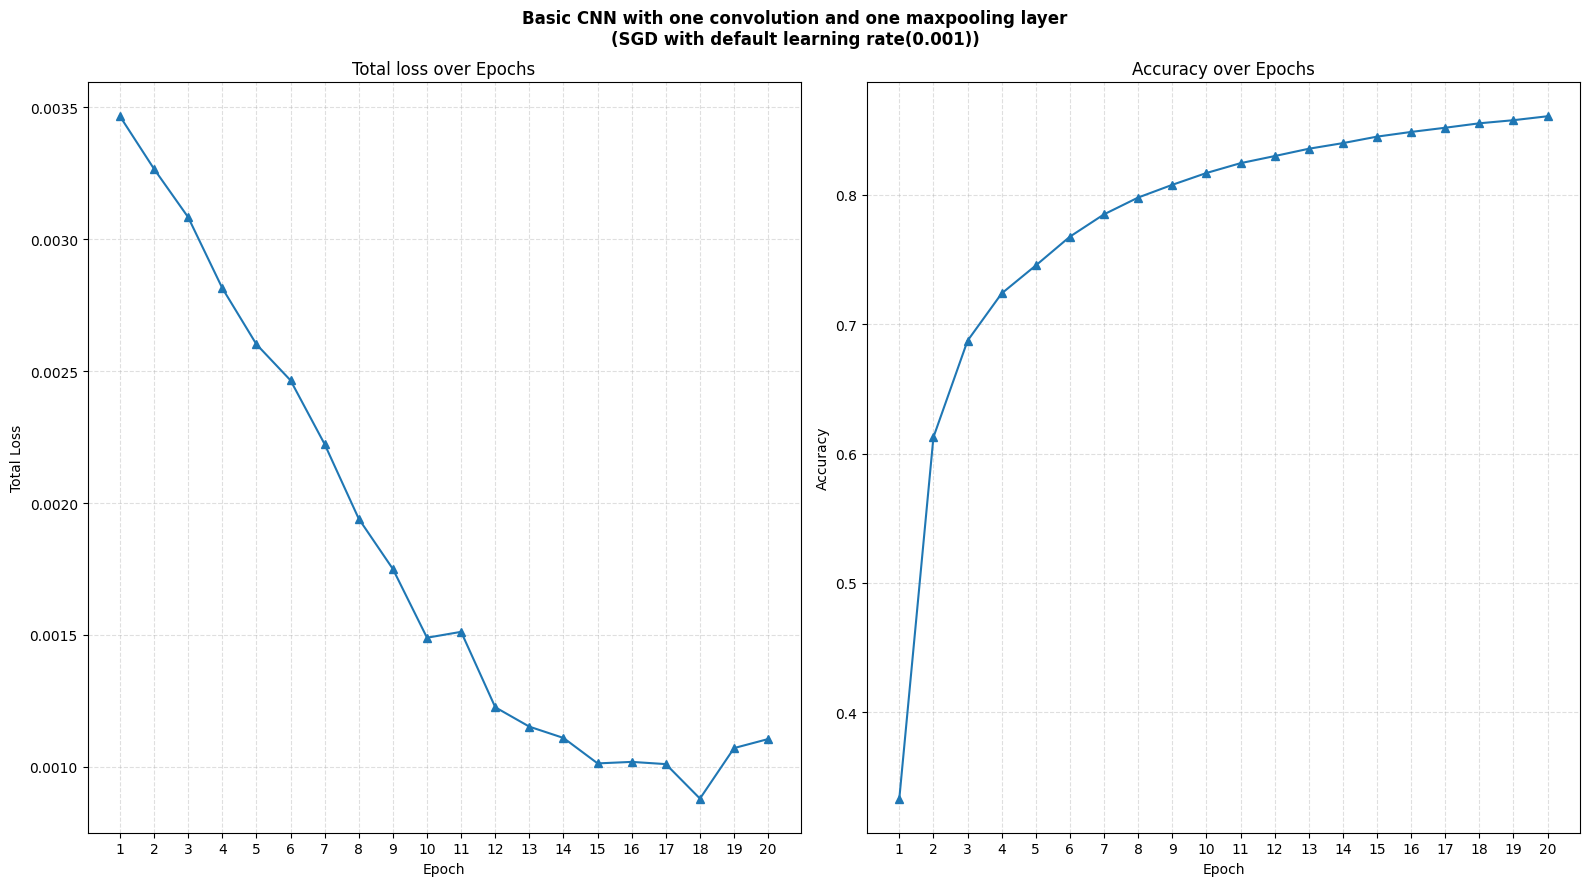

<Figure size 640x480 with 0 Axes>

In [15]:
plot_metrics(losses, accuracies)

### Evaluate on test set

In [16]:
# define an evaluation function
def evaluate(model, dataloader, loss_function):
    # set model to evaluate mode
    model.eval()
    
    test_loss = correct_pred = total_pred = 0

    # disable gradients
    with torch.no_grad():
        for images, labels in dataloader:
            # move to `device`
            images, labels = images.to(device), labels.to(device)

            # make predictions
            outputs = model(images)

            # loss
            loss = loss_function(outputs, labels)
            # total loss
            test_loss += loss.item()*images.size(0)

            # extract a prediction for labels
            predicted = torch.argmax(outputs, dim=1)

            # calculate total correct predictions
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)

        # compute metrics
        test_accuracy = correct_pred/total_pred
        return test_loss/total_pred, test_accuracy 

In [17]:
# evaluate the test set
test_loss, test_accuracy = evaluate(basic_cnn_model, testset_loader, loss_function)

In [18]:
print(f"Loss on train set: {losses[-1]:.4f}")
print(f"Accuracy on train set: {accuracies[-1]:.4f}")
print(f"Loss on test set: {test_loss:.4f}")
print(f"Accuracy on test set: {test_accuracy:.4f}")

Loss on train set: 0.0011
Accuracy on train set: 0.8608
Loss on test set: 0.5418
Accuracy on test set: 0.8720


Observe the accuracies of train and test set:
* Accuracy on train set = 0.8608 = 86.08 %
* Accuracy on test set = 0.8720 = 87.20 %

Can we do better ? **Yes**<br>
In the next sections/notebooks, we will explore how can we improve the accuracy of our model.
### Visualize the prediction

In [19]:
# now visualize the prediction
def prediction_and_image(model, dataloader):
    # select an image randomly
    test_image, test_label = dataloader[np.random.choice(10000)]
    test_image = test_image.to(device).unsqueeze(0)

    # put the model in evaluation (inference) mode
    model.eval()
    predictions_test_image = model(test_image)
    probabilities = torch.nn.functional.softmax(predictions_test_image, dim=1)
    probabilities = probabilities.cpu().detach().numpy() #.cpu() to copy tensor to memory first


    plt.Figure(figsize=(20,20))

    plt.subplot(1,2,1)
    classes = [i for i in range(10)]
    x_values = classes
    x_labels = [str(i) for i in x_values]
    plt.bar([i for i in range(10)], probabilities[0])
    plt.xticks(x_values, x_labels)

    plt.subplot(1,2,2)
    plt.imshow(test_image[0,0,:,:].cpu(), cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])

    model_output = np.argmax(probabilities)
    print(f"The image is of the digit (as recognized by our model): {model_output}")

# Don't touch this area
#### ===============================================================================================================
#### ==================================================================================================================================

The image is of the digit (as recognized by our model): 0


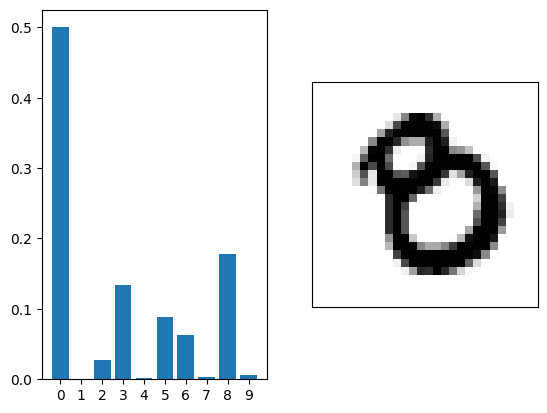

In [25]:
prediction_and_image(basic_cnn_model, test_dataset)

#### ===============================================================================================================

As we can see from the above execution, the image is 8, but out model predicted it as 0.<br>
This indicates the need for adding more layers and changing the optimizers to imporve the model accuracy.

The image is of the digit (as recognized by our model): 3


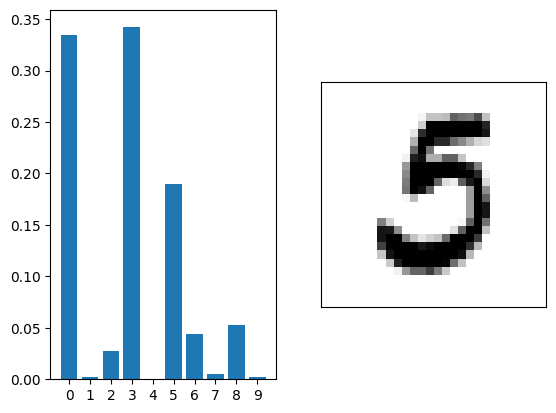

In [26]:
prediction_and_image(basic_cnn_model, test_dataset)

**The image is 5, but out model predicted it as 3.**

In [27]:
# After training
state = {
    "model_state": basic_cnn_model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "epoch": EPOCHS
}
torch.save(state, "../checkpoints/basic_cnn_1.pt")